# CORDEX-CORE urban vs rural vicinity analysis

...

## Load libraries

Here we load the required libraries to execute the notebook. Note that specific code from dedicated scripts (`utils.py`, `urban_areas.py`, ...) is also loaded here.

In [25]:
%load_ext autoreload
%autoreload 2
    
import cartopy.crs as ccrs
import cf_xarray as cfxr
import dask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import xarray as xr
import glob


from icecream import ic
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point
from skimage.morphology import dilation, square
from utils import RCM_DICT, MODEL_DICT, YAMLconfig

from urban_areas import (
    load_fix_variables,
    fix_sftuf,
    Urban_vicinity,
    load_variable,
    kelvin2degC,
    load_ucdb_city,
)
from GHCNd_stations import (
    load_ghcnd_stations,
    get_ghcnd_df,
    get_valid_timeseries,
    available_vars,
    get_season,
    inside_city
)
from plot_functions import (
    plot_climatology,
    plot_time_series
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Input parameters

These parameters define the behaviour of the notebook, by selecting the `city`, `variable`, and some other items which are mostly self-explanatory. _(Explain here those with are not)_

This cell is tagged `parameters`, in order to be managed externally by the [`papermill` package](https://papermill.readthedocs.io/en/latest).

In [26]:
abbr_city = 'BuenosAires'

variable = 'tasmin'
urban_var = 'sftimf'
observations = True
domain = 'SAM-22'
model = 'REMO' # REMO/RegCM
scenario = 'evaluation'
root_esgf = '/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/'
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'


lon_city =-58.416
lat_city = -34.559

urban_th = 40
urban_sur_th = 10
orog_diff = 1000
sftlf_th = 0
scale = 2
min_city_size = 0 # remove small urban centers (numbero of cells)
lon_lim = 1
lat_lim = 1

Create a directory to save the results for this particular city and model

In [27]:
base_output_dir = f'results_ucdb'
cities = YAMLconfig('selected_cities.yaml')

if domain in ["EUR-11","EUR-22"]:
    output_dir = f"{base_output_dir}/{abbr_city}"
    city = cities[f"{abbr_city}-{domain}_{model}_{urban_var}"]['name']
else:
    city = cities[f"{abbr_city}_{model}_{urban_var}"]['name']
    output_dir = f"{base_output_dir}/{abbr_city}"

model_str = RCM_DICT[domain][model]
os.makedirs(output_dir, exist_ok = True)

In [28]:
domain_resolution = int(domain.split('-')[1])
base_filename = f'{urban_var}_{abbr_city}-{domain}_ECMWF-ERAINT_{scenario}_r1i1p1_{model_str}'
if domain in ["EUR-11","EUR-22"]:
    base_filename = f'{urban_var}_{abbr_city}_ECMWF-ERAINT_{scenario}_r1i1p1_{model_str}'

## Define urban areas and vicinity

### Load fix variables
Load fix (static) variables, such as urban fraction (sfturf), terrain elevation (orog) or land fraction (sftlf). The urban fraction needs some fixes to align the coordinates with the rest of the variables. These are applied in the `fix_sfturf` function.

In [29]:
ds_sftuf, ds_orog, ds_sftlf = load_fix_variables(domain, model, root_esgf, root_nextcloud, urban_var)

/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG//new/REMO/sftimf/sftimf_SAM-22_*.nc


Add parameters to the function

In [30]:
URBAN = Urban_vicinity(
    urban_th, 
    urban_sur_th, 
    orog_diff, 
    sftlf_th,
    scale,
    min_city_size,
    urban_var,
    lon_city,
    lat_city,
    lon_lim,
    lat_lim,
    model_str,
    domain)

Crop area around de city

In [31]:
ds_sftuf = URBAN.crop_area_city(ds_sftuf, domain_resolution)
ds_orog = URBAN.crop_area_city(ds_orog, domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds_sftlf, domain_resolution)

In [32]:
from shapely.geometry import Point

def create_urban_dataset(ds, city_geometry):
    """
    Create a new dataset with an 'sftimf' variable set to 100 where grid points are inside the city geometry.
    
    Args:
    - ds (xarray.Dataset): The original dataset with 'lat' and 'lon' coordinates.
    - city_geometry (GeoDataFrame): The geometry or the city boundary to check against (must be a valid GeoDataFrame).
    
    Returns:
    - xarray.Dataset: The new dataset with 'sftimf' values updated.
    """
    
    # Create a new array for 'sftimf' with the same shape as the input dataset
    sftimf = np.zeros(ds['lat'].shape)

    # Ensure city_geometry is a GeoDataFrame and contains a valid geometry column
    if isinstance(city_geometry, gpd.GeoDataFrame) and not city_geometry.empty:
        # Assuming city_geometry is a GeoDataFrame, extract the first geometry (assuming one city geometry)
        city_polygon = city_geometry.geometry.iloc[0]        
        # Ensure it's a Polygon or MultiPolygon
        if city_polygon.is_valid and (city_polygon.geom_type == 'Polygon' or city_polygon.geom_type == 'MultiPolygon'):
            # Iterate over all grid points
            for i in range(ds.dims['rlat']):
                for j in range(ds.dims['rlon']):
                    lon_value = ds['lon'].values[i, j]
                    lat_value = ds['lat'].values[i, j]
                    
                    # Create a Point object from the lon/lat of the current grid cell
                    point = Point(lon_value, lat_value)
                    
                    # Check if the point is inside the city geometry
                    if city_polygon.contains(point):
                        sftimf[i, j] = 100
        else:
            raise ValueError("The geometry in city_geometry is not a valid Polygon or MultiPolygon.")
    else:
        raise ValueError("city_geometry must be a non-empty GeoDataFrame.")

    # Add the 'sftimf' variable to the dataset
    ds['sftimf'] = xr.DataArray(sftimf, coords=[ds['rlat'], ds['rlon']], dims=["rlat", "rlon"])

    return ds


In [33]:
ucdb_info = gpd.read_file("/home/yaizaquintana/Desktop/DATA/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg")
#ucdb_info = gpd.read_file('/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/GHS_FUA_UCD/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg')

# Reproyección a EPSG:4326 solo si no está ya en ese CRS
ucdb_info = ucdb_info.to_crs(crs='EPSG:4326')

# Filtrar por la ciudad seleccionada
if city == 'PortoAlegre':
    ucdb_city = ucdb_info.query('UC_NM_MN == "Porto Alegre"')
elif city == 'BuenosAires':
    ucdb_city = ucdb_info.query('UC_NM_MN == "Buenos Aires"')
elif city == 'London':
    ucdb_city = ucdb_info[ucdb_info['CTR_MN_NM'] == 'United Kingdom']
elif city == 'Santiago':
    ucdb_city = ucdb_info[ucdb_info['CTR_MN_NM'] == 'Chile']
elif city == 'Barcelona':
    ucdb_city = ucdb_info[ucdb_info['CTR_MN_NM'] == 'Spain']
elif city == 'Dhaka':
    ucdb_city = ucdb_info[ucdb_info['CTR_MN_NM'] == 'Bangladesh']
elif city == 'Naples':
    ucdb_city = ucdb_info[ucdb_info['CTR_MN_NM'] == 'Italy']
else:
    # Si la ciudad no está en las opciones anteriores, filtramos por el nombre
    ucdb_city = ucdb_info.query('UC_NM_MN == @city')

# Asegurarse de que la geometría de la ciudad está en EPSG:4326
ucdb_city = ucdb_city.to_crs(crs='EPSG:4326')

# Crear el dataset con la función create_urban_dataset
ds_sftuf = create_urban_dataset(ds_orog, ucdb_city)


/tmp/ipykernel_247414/1205134132.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in range(ds.dims['rlat']):
/tmp/ipykernel_247414/1205134132.py:26: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for j in range(ds.dims['rlon']):


Define masks using the parameters above

In [34]:
sftuf_mask, sftuf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sftuf, 
    ds_orog, 
    ds_sftlf
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [35]:
urmask = URBAN.select_urban_vicinity(
    sftuf_mask, 
    orog_mask,
    sftlf_mask,
    sftuf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

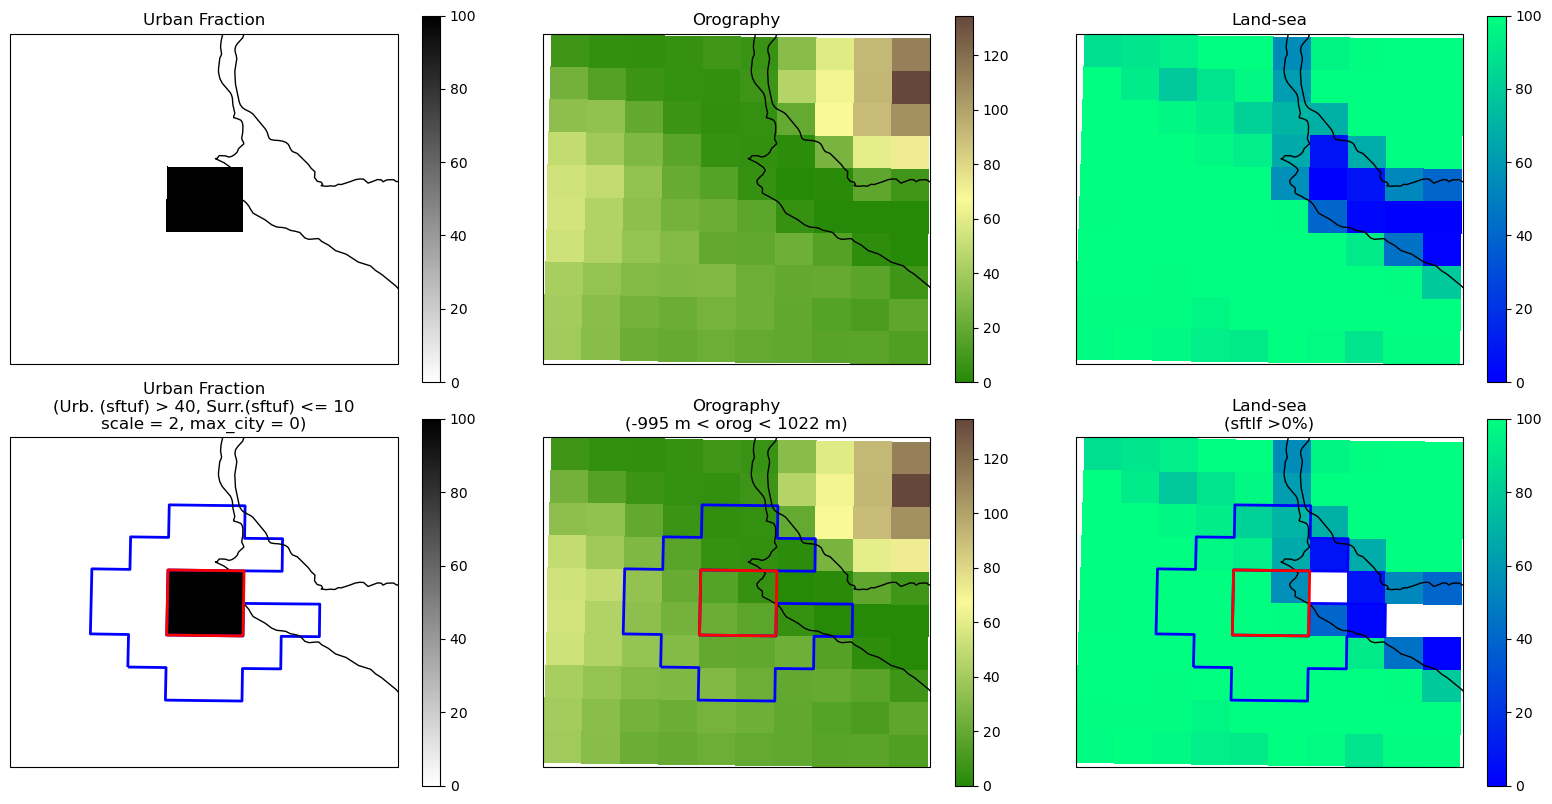

In [36]:
fig = URBAN.plot_fix_variables(ds_sftuf, ds_orog, ds_sftlf,
                                 sftuf_mask, orog_mask, sftlf_mask,
                                 urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [37]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")
ds_sftuf.to_netcdf(f"{output_dir}/sfturf_{base_filename}_fx.nc")